In [172]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial import ConvexHull


# Análise Exploratória de Dados

Autor: Lara Esquivel de Brito Santos

Neste notebook está descreve o passo a passo da análise exploratória dos dados imobiliários contidos no arquivo  teste_indicium_precificacao.csv

In [124]:
df = pd.read_csv('teste_indicium_precificacao.csv') #leitura do csv
df.head() #primeiros registros do dataframe

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


Cada coluna possui os seguintes tipos de dados, segundo o pandas:

In [125]:
df.dtypes

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

- **id**: Embora seja um valor `int64`, é um identificador.
- **nome**: Nome do anúncio, variável **categórica nominal**.
- **host_id**: é um identificador do anfitrião.
- **host_name**: Variável **nominal**, representando o nome do anfitrião.
- **bairro_group**: Variável **nominal**, que categoriza os grupos de bairros.
- **latitude**: Variável **contínua**, representando uma coordenada geográfica.
- **longitude**: Variável **contínua**, representando uma coordenada geográfica.
- **room_type**: Variável **nominal**, descrevendo o tipo de quarto.
- **price**: Representa o preço do aluguel. Embora devesse ser uma variável **contínua** (podendo incluir valores decimais), nesta base de dados não possui valores decimais.
- **minimo_noite**: Variável **discreta**, pois conta o número mínimo de noites para o aluguel temporário.
- **numero_de_reviews**: Variável **discreta**, que representa a contagem de avaliações.
- **ultima_review**: É uma data. Porém, o pandas não reconheceu como tal e precisa ser convertida para o formato `datetime`.
- **reviews_por_mes**: Variável **contínua**, representando a média de avaliações mensais.
- **calculated_host_listings_count**: Variável **discreta**, pois é uma contagem.
- **disponibilidade**: Variável **discreta**, que indica o número de dias em que o anúncio está disponível para reserva.





Os nulos incluem os atributos nome do anúncio, o nome do hospedador do anúncio, a ultima review e as reviews por mês, incialmente não tratarei isto

In [126]:
df.isnull().sum() #mostrando o número de registros de cada coluna que possuem valor vazio

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

## Analisando dados básicos para criar hipóteses

Considerando que o cliente quer um modelo de previsão de preços, o questionamento incial:  é como os atributos influenciam o preço? 

Os primeiros atributos que provavelmente afetam é o tipo de imóvel e o bairro, uma casa de três quartos e dois banheiros por ocupar uma área maior deveria ser mais cara que um apartamento de dois quartos e um banheiro, todavia o bairro do imóvel afeta esses valores, por característica do próprio bairro, como sendo mais distante do centro ou mais proximo de uma universidade.

Consequentemente latitude e longitude estão relacionadas ao bairro, o número total de reviews e as reviews por mês podem estar relacionadas ao bairro populares, onde as pessoas mais buscam. Enquanto a última review indica se o anuncio está ativo, reviews mais antigas podem ter o preço mais baixo. Enquanto disponibilidade está relacionada a sazionalidade e demanda, o que pode influenciar o preço tanto positivamente quanto negativamente.

In [127]:
df.select_dtypes(include=['number']).describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [128]:
df.select_dtypes(exclude=['number']).describe()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,48878,48873,48894,48894,48894,38842
unique,47904,11452,5,221,3,1764
top,Hillside Hotel,Michael,Manhattan,Williamsburg,Entire home/apt,2019-06-23
freq,18,417,21661,3920,25409,1413


Em cima desses dados o que podemos perceber que temos valores discrepantes de preço, o menor valor é 0 doláres e o maior valor é 10.000 doláres. Inclusive são estranhos os registros cujo o valor de aluguel está como 0 de inicio, e da mesma forma para disponibilidade, isto pode ser ruídos na base de dados, ou o que pode ser cogitado é que é um imóvel comunitário por isso tem valor 0, enquanto a disponibilidade é o fato do anunciante ter tirado o anúncio de circuilação, ou não ter mais locações, isso corresponde ao primeiro quartil do conjunto de dados, não deve ser um ruído. 

Todavia quando fazemos um histograma usando os tipos de residência cujo o valor da locação é 0, é estranho porque ninguém colocaria um anúncio de imóvel para alugar por esse valor, cogitei que poderia ser algo de imóveis compartilhados comunitários mas o valor aparece entre outros tipos de imóveis. Por esse motivo, removi todos os registros cujo a locação tem valor 0.

In [129]:
df.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

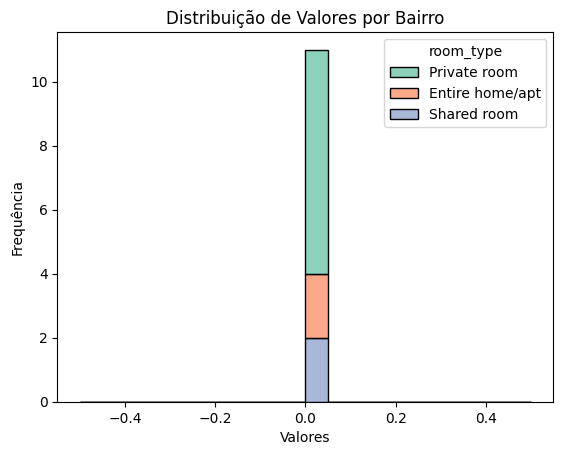

In [130]:
sns.histplot(data=df[df['price']==0], x='price', hue='room_type', multiple='stack', bins=20, palette='Set2')
plt.title('Distribuição de Valores por Bairro')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

In [131]:
df = df[df['price'] != 0]

Analisando o grupo de bairros por valor do aluguel decidi inicialmente criar um boxplot para verificar a distribuição dos dados e dos valores das locações, grupos de bairro porque temos 221 bairros registrados, e seria menos visivel inicialmente. Como na tabela de descrição gerada pelo pandas vemos a diferença entre o terceiro quartil e o valor máximo ($9825), já era esperado outliers, todavia devido a discrepança fiz dois boxplot, um para realmente ver essa estátistica e outro para ver a distribuição dentro dos grupos de bairros.

Todos os bairros tem valores exorbitantes, mas Manhattan e Brooklyn tem valores mais distribuídos e medianas maiores, ou seja tem mais imóveis com valors mais altos, do que os outros grupos de bairro.

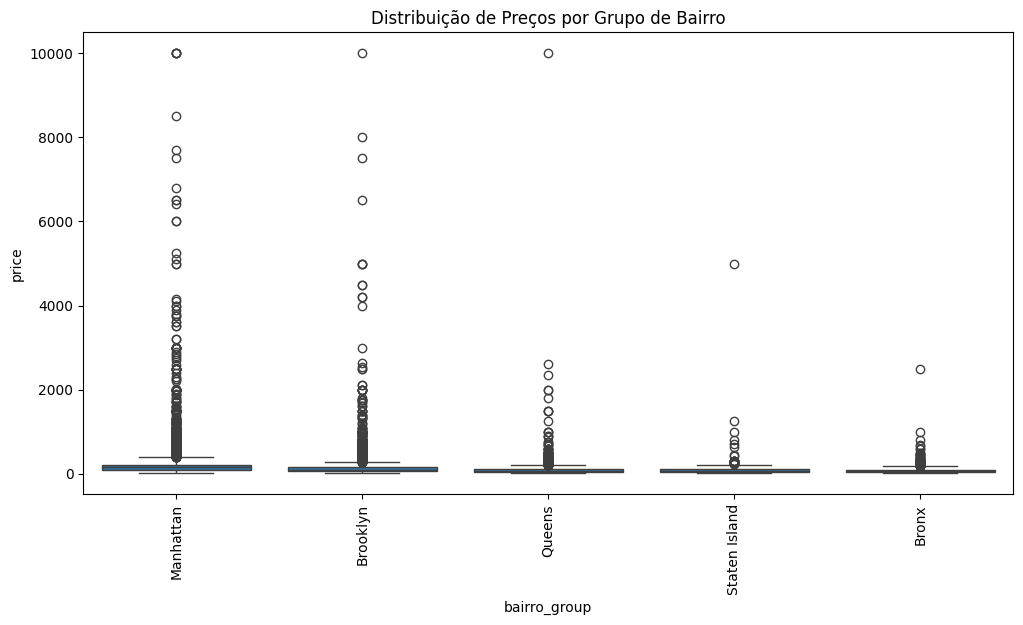

In [132]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='bairro_group', y='price', data=df)
plt.title('Distribuição de Preços por Grupo de Bairro')
plt.xticks(rotation=90)
plt.show()

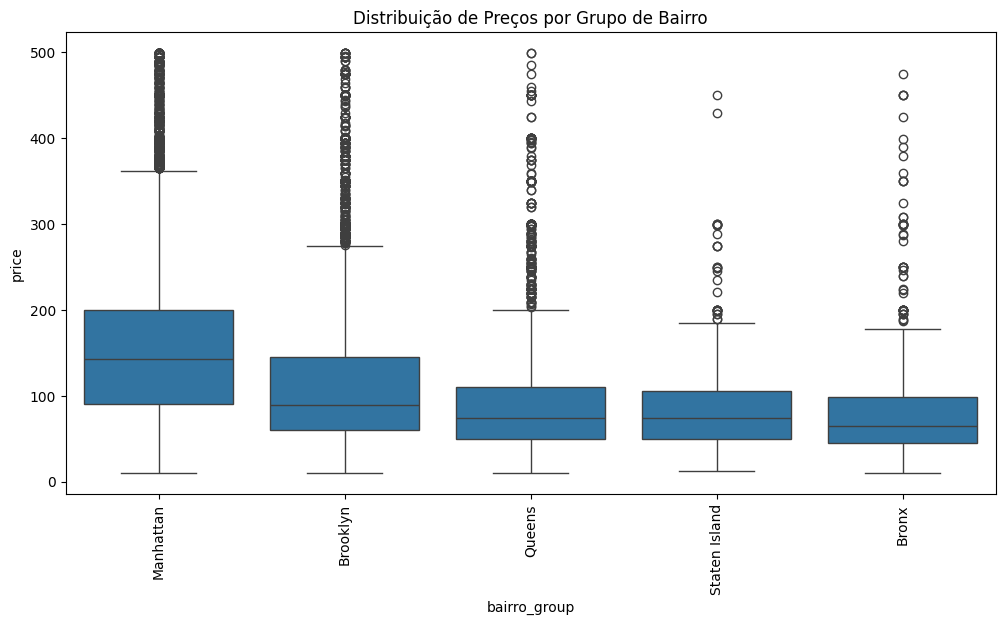

In [133]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='bairro_group', y='price', data=df[df['price'] < 500])
plt.title('Distribuição de Preços por Grupo de Bairro')
plt.xticks(rotation=90)
plt.show()

Dessa forma, pensei em plotar um histograma para ver como esses dados se distribuem ao longo dos valores, todavia a concentração abaixo de 1000 é muito maior, o que já era esperado dado a mediana e os terceiro quartil da coluna price. Dessa forma, plotei o histograma normalmente, para valores abaixo de 1000 e para os valores acima de 1000.

Podemos observar que:
    <li>O grupo Manhattan e Brooklyn está praticamente por todo o histograma </li>
    <li>Mas isso não ocorre com os outros grupos de bairros</li>
    <li>Então para quais bairros do grupo estão contidos dentro dessas faixas do histograma? Por exemplo quais bairros do Queens tem alguel no valor de $10000? Isso é um valor real ou um ruído da base de dados. Isso vale para cada grupo de bairro.</li>

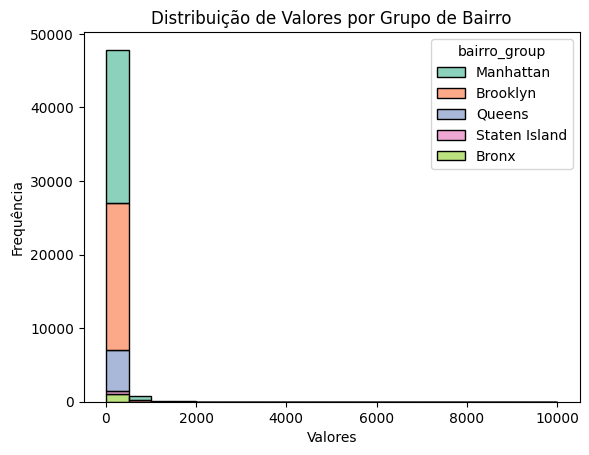

In [134]:
sns.histplot(data=df, x='price', hue='bairro_group', bins=20, multiple='stack', palette='Set2')
plt.title('Distribuição de Valores por Grupo de Bairro')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

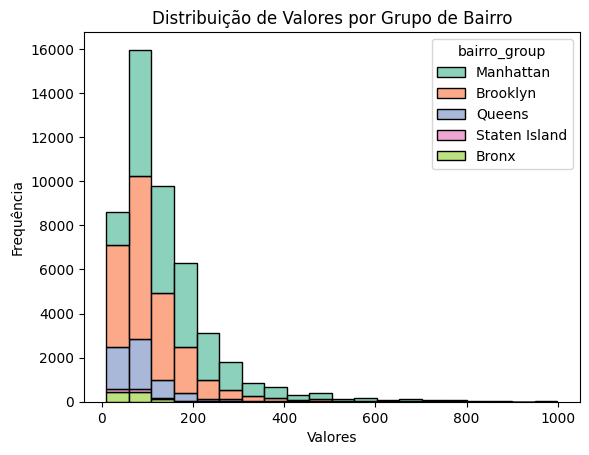

In [135]:
sns.histplot(data=df[df['price']<1000], x='price', hue='bairro_group', bins=20, multiple='stack', palette='Set2')
plt.title('Distribuição de Valores por Grupo de Bairro')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

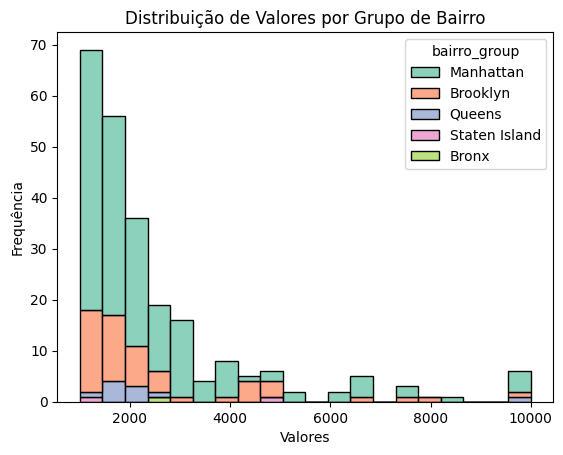

In [136]:
sns.histplot(data=df[df['price'] > 1000], x='price', hue='bairro_group', bins=20, multiple='stack', palette='Set2')
plt.title('Distribuição de Valores por Grupo de Bairro')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

Assim pensei incialmente um gráfico que pudesse representar os bairros e os valores dos imóveis desses bairros, todavia devido ao grande número de bairros dentro do grupo de bairros, optei por encontrar semelhanças inciais dentre os dados de coordenadas. Achei interessante a concentração de imóveis de alto padrão  no centro do gráfico (em torno da latitude 40,7) aparenta ter uma área de alto padrão naquela zona. Penso se esses imóveis por serem de alto padrão são alugados frequentemente? Se não são por serem caros? Existe muitas reviews sobre esses imóveis?

In [137]:
df.groupby('bairro_group')['bairro'].nunique()

bairro_group
Bronx            48
Brooklyn         47
Manhattan        32
Queens           51
Staten Island    43
Name: bairro, dtype: int64

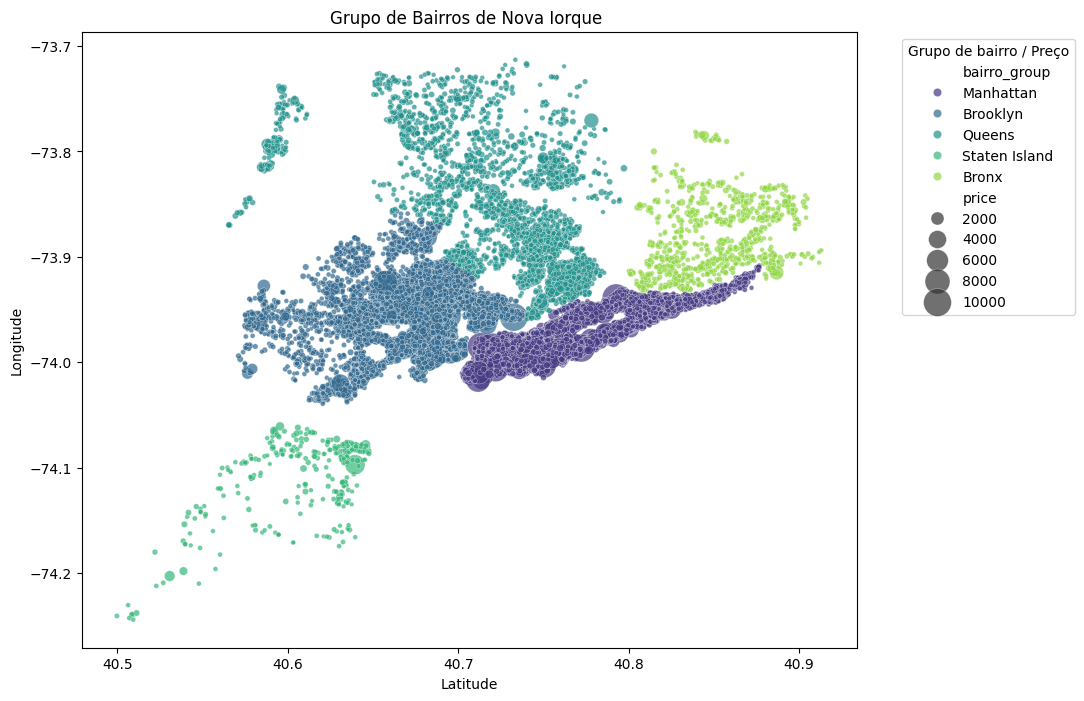

In [211]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df, x='latitude', y='longitude', 
    size='price', sizes=(10, 400), hue='bairro_group', palette='viridis', alpha=0.7
)

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Grupo de Bairros de Nova Iorque ")
plt.legend(title='Grupo de bairro / Preço', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Ao olhar melhor esses grupos de bairros, dados seus dados estatísticos descritos abaixo, o que podemos concluir:

* O Bronx é o grupo com a menor média de preço, no geral os imóveis são mais baratos 
* Todos os grupo de bairros possuem médias maiores que a mediana, o que mostra que a distribuição em todos os grupos de bairro possui uma calda para esquerda
* Manhattan possui a maior média e o maior desvio padrão, lembrando que maior parte dos imóveis está localizada em Manhattan, logo também possue a maior variedade de valores de imóveis.
* O Queens embora tenha imóveis de mais altos valores que o Staten Island, possui muitos imóveis de valores mais baixos e isso fez com que a média de preços do bairro caisse.
* Enquanto o State Island tem o maior valor mínimo de ímovel.

In [ ]:
df[df['bairro_group'] == 'Bronx'].describe()


,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,1.090000e+03,1.090000e+03,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,875.000000,1090.00000,1090.000000
mean,2.273712e+07,1.055859e+08,40.848319,-73.884550,87.577064,4.563303,25.977982,1.837006,2.23211,165.794495
std,1.023846e+07,8.711597e+07,0.026725,0.032833,106.725371,15.638775,42.225003,1.674062,2.37106,135.304079
min,4.409600e+04,1.222100e+04,40.800110,-73.931900,10.000000,1.000000,0.000000,0.020000,1.00000,0.000000
25%,1.616891e+07,2.159430e+07,40.826628,-73.911068,45.000000,1.000000,1.000000,0.480000,1.00000,37.000000
50%,2.389267e+07,9.129115e+07,40.846205,-73.892585,65.000000,2.000000,9.000000,1.380000,1.00000,148.000000
75%,3.190046e+07,1.792933e+08,40.869618,-73.858413,99.000000,3.000000,32.000000,2.790000,2.00000,313.750000
max,3.644225e+07,2.738773e+08,40.913060,-73.781580,2500.000000,365.000000,321.000000,10.340000,37.00000,365.000000


In [139]:
df[df['bairro_group'] == 'Brooklyn'].describe()


,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,2.009400e+04,2.009400e+04,20094.000000,20094.000000,20094.000000,20094.000000,20094.000000,16437.000000,20094.000000,20094.000000
mean,1.825673e+07,5.671863e+07,40.685034,-73.951201,124.437693,6.055738,24.198417,1.283078,2.283119,100.204141
std,1.083501e+07,7.261212e+07,0.027401,0.025479,186.901408,17.635297,44.346333,1.516014,5.274623,126.269798
min,3.831000e+03,2.438000e+03,40.571150,-74.039420,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,8.700149e+06,5.611518e+06,40.672590,-73.963500,60.000000,2.000000,1.000000,0.180000,1.000000,0.000000
50%,1.887273e+07,2.291993e+07,40.687520,-73.951750,90.000000,3.000000,6.000000,0.660000,1.000000,28.000000
75%,2.785047e+07,7.900130e+07,40.704968,-73.935930,150.000000,5.000000,25.000000,1.980000,2.000000,188.000000
max,3.648506e+07,2.743076e+08,40.738900,-73.856760,10000.000000,999.000000,488.000000,14.000000,232.000000,365.000000


In [140]:
df[df['bairro_group'] == 'Manhattan'].describe()


,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,2.166000e+04,2.166000e+04,21660.000000,21660.000000,21660.000000,21660.000000,21660.000000,16632.000000,21660.000000,21660.000000
mean,1.877484e+07,6.783312e+07,40.765063,-73.974607,196.884903,8.579409,20.986565,1.272131,12.791874,111.984580
std,1.116818e+07,7.936533e+07,0.038463,0.022139,291.386838,24.051383,42.573021,1.628252,48.235813,132.678717
min,2.595000e+03,2.845000e+03,40.702340,-74.018510,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.160997e+06,8.525354e+06,40.731820,-73.991690,95.000000,1.000000,1.000000,0.170000,1.000000,0.000000
50%,1.911665e+07,3.065628e+07,40.760880,-73.980425,150.000000,3.000000,4.000000,0.610000,1.000000,36.000000
75%,2.954131e+07,1.069502e+08,40.795093,-73.953837,220.000000,6.000000,19.000000,1.890000,2.000000,230.000000
max,3.648724e+07,2.743213e+08,40.876650,-73.908550,10000.000000,1250.000000,607.000000,58.500000,327.000000,365.000000


In [143]:
df[df['bairro_group'] == 'Queens'].describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,5.666000e+03,5.666000e+03,5666.000000,5666.000000,5666.000000,5666.000000,5666.000000,4574.000000,5666.000000,5666.000000
mean,2.175500e+07,9.615680e+07,40.731531,-73.872775,99.517649,5.181433,27.700318,1.941200,4.060184,144.451818
std,1.037687e+07,8.424324e+07,0.040368,0.056988,167.102155,15.028725,51.955853,2.213108,12.445003,135.538597
min,1.293700e+04,3.211000e+03,40.565460,-73.959270,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.396042e+07,2.121601e+07,40.707410,-73.917420,50.000000,1.000000,1.000000,0.370000,1.000000,2.000000
50%,2.256460e+07,6.827146e+07,40.744790,-73.895045,75.000000,2.000000,7.000000,1.210000,1.000000,98.000000
75%,3.076880e+07,1.580312e+08,40.759780,-73.829602,110.000000,3.000000,32.000000,2.790000,3.000000,286.000000
max,3.648436e+07,2.742256e+08,40.797210,-73.712990,10000.000000,500.000000,629.000000,20.940000,103.000000,365.000000


In [144]:
df[df['bairro_group'] == 'Staten Island'].describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,3.730000e+02,3.730000e+02,373.000000,373.000000,373.000000,373.000000,373.000000,314.000000,373.000000,373.000000
mean,2.159747e+07,9.853360e+07,40.610225,-74.105805,114.812332,4.831099,30.941019,1.872580,2.319035,199.678284
std,1.039310e+07,7.954340e+07,0.032419,0.036400,277.620403,19.727605,44.830766,1.685495,1.915580,131.852000
min,4.288200e+04,1.552300e+04,40.499790,-74.244420,13.000000,1.000000,0.000000,0.020000,1.000000,0.000000
25%,1.553243e+07,2.505997e+07,40.593720,-74.123930,50.000000,1.000000,1.000000,0.702500,1.000000,78.000000
50%,2.297702e+07,9.249339e+07,40.621540,-74.089300,75.000000,2.000000,12.000000,1.410000,1.000000,219.000000
75%,3.008296e+07,1.581790e+08,40.634740,-74.081070,110.000000,3.000000,42.000000,2.615000,3.000000,333.000000
max,3.643834e+07,2.725577e+08,40.647790,-74.060920,5000.000000,365.000000,333.000000,10.120000,8.000000,365.000000


Outros dados estásticos que podemos observar é que a distribuição do mínimo noites é semelhante em todos os grupos de bairro, os quartis de Staten Island, Queens e do Bronx são os mesmo, enquanto a mediana dos valores de alugeis do Staten Island e do Queens são a mesma, e a do Bronx é levemente menor.  Possa ser que tenha uma relação com o mínimo de noites e o preço, pois se o cliente é forçado a ficar mais noites no imóvel, ele consequentemente vai pagar mais por esse, já que ficou por mais dias. Pensando dessa forma podemos olhar para a disponibilidade da mesma forma, todavia o preço pode ser maior ou menor, pois pode ser que os host aluguem para temporadas mais caras e o preço suba consideravelmente mesmo em disponibilidades menores ou possa oferecer maior disponibilidade com desconto em épocas fora de alguma temporada. 

Quanto ao número de reviews observamos que tem mais valores nos grupos mais populares, Manhattan e Brooklyn, todavia os imóveis com maior distribuição de reviews se encontram no Queens. Por Manhattan e Brooklyn terem mais imóveis, possuem o maior número de reviews por mês. Outra coisa Manhattan e o Queens possuem quantidades de listagem hosting distribuidas mais altas, pode ser que os imóveis de alto padrão tenham o mesmo anfritrião.



In [220]:
df[df['bairro_group'] == 'Bronx'].select_dtypes(exclude='number').describe()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,1089,1089,1090,1090,1090,875
unique,1076,652,1,48,3,259
top,Prolonged Traveler's Dream (a month first & more),Vie,Bronx,Kingsbridge,Private room,2019-06-30
freq,3,13,1090,70,651,48


In [221]:
df[df['bairro_group'] == 'Brooklyn'].select_dtypes(exclude='number').describe()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,20088,20085,20094,20094,20094,16437
unique,19690,6074,1,47,3,1544
top,Brooklyn Apartment,Michael,Brooklyn,Williamsburg,Private room,2019-06-23
freq,12,159,20094,3919,10125,575


In [222]:
df[df['bairro_group'] == 'Manhattan'].select_dtypes(exclude='number').describe()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,21651,21651,21660,21660,21660,16632
unique,21263,5971,1,32,3,1565
top,Harlem Gem,Sonder (NYC),Manhattan,Harlem,Entire home/apt,2019-06-23
freq,7,327,21660,2658,13198,599


In [223]:
df[df['bairro_group'] == 'Queens'].select_dtypes(exclude='number').describe()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,5666,5664,5666,5666,5666,4574
unique,5583,2424,1,51,3,788
top,Hillside Hotel,Kazuya,Queens,Astoria,Private room,2019-07-01
freq,18,79,5666,900,3372,206


In [225]:
df[df['bairro_group'] == 'Staten Island'].select_dtypes(exclude='number').describe()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,373,373,373,373,373,314
unique,372,220,1,43,3,116
top,New York home ferry ride from Manhattan.,Maria,Staten Island,St. George,Private room,2019-07-01
freq,2,9,373,48,188,22


Ao analisar os dados estatísticos categóricos, podemos observar que o tipo de imóvel mais comum são os quartos privados, com excessão de Manhattan que são as casas e os apartamentosm. O periódo mais frequente das últimas reviews pode indicar a epóca de algum evento, como o dia da indepedência e a busca de alocações na cidade para o show de fogos, mas é necessário analisar com mais detalhes.